<a href="https://colab.research.google.com/github/iampatgrady/Colaboratory-Analytics-Demos/blob/master/Using%20Kmeans%20on%20GA%20BQ%20Export%20__TABELS__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Authenticate the Notebook to your Google Account
from google.colab import auth
auth.authenticate_user()

In [0]:
#@title Set default project
project_id = "as-dev-pat" #@param {type:"string"}
from google.cloud.bigquery import magics
magics.context.project = project_id

In [0]:
#@title Query features
%%bigquery df
SELECT
  EXTRACT(DAYOFWEEK FROM PARSE_DATE('%Y%m%d', SPLIT(table_id, "_")[OFFSET(2)])) as dow,
  row_count,
  UNIX_SECONDS(TIMESTAMP( PARSE_DATE('%Y%m%d',SPLIT(table_id, "_")[OFFSET(2)]))) as creation_time,
  size_bytes / POW(2,20) as MBs
FROM `bigquery-public-data.google_analytics_sample.__TABLES__`
WHERE REGEXP_CONTAINS(table_id, r"ga_sessions_\d{8}")
/* Review output, it looks like cutting off data prior to 1.48e9 epoch will improve quality */
--and UNIX_SECONDS(TIMESTAMP( PARSE_DATE('%Y%m%d',SPLIT(table_id, "_")[OFFSET(2)]))) > 1.48e9

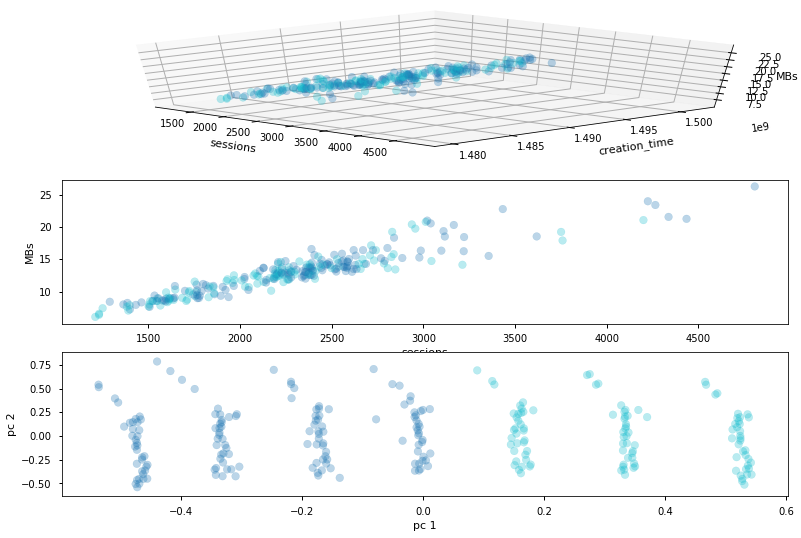

In [6]:
#@title Generate `k` clusters { run: "auto", vertical-output: true }
import sklearn
from sklearn import preprocessing
import pandas as pd
from sklearn import cluster
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
plt.style.use('seaborn-notebook')

k = 2 #@param {type:"slider", min:1, max:5, step:1}
feature = "creation_time" #@param ["creation_time", "dow"]
columns = df.columns
matrix = df.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(matrix)
df_scaled = pd.DataFrame(x_scaled)
df_scaled.columns = columns

km = sklearn.cluster.KMeans(n_clusters=k,random_state=42)
km.fit(df_scaled)
labels = km.labels_
clusters = pd.DataFrame({'labels': labels})
output = df.join(clusters)

pca = PCA(n_components=2,random_state=42)
principalComponents = pca.fit_transform(df_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc 1', 'pc 2'])
pcadf = pd.concat([principalDf, output[['labels']]], axis = 1)

#plotting
fig = plt.figure(figsize=(13, 9))
ax1 = fig.add_subplot(311, projection='3d')
ax1.scatter(output.row_count,  output[feature], output.MBs, c=output.labels, cmap='tab10', marker='o', s=60, alpha=.3)
ax1.set_xlabel('sessions', labelpad=25)
ax1.set_ylabel(feature, labelpad=25)
ax1.set_zlabel('MBs')
ax1.view_init(40,-45)

ax2 = fig.add_subplot(312)
ax2.scatter(output.row_count,  output.MBs, c=labels, cmap='tab10', marker='o', s=60, alpha=.3)
ax2.set_xlabel('sessions')
ax2.set_ylabel('MBs')

ax3 = fig.add_subplot(313)
ax3.scatter(pcadf['pc 1'],  pcadf['pc 2'], c=labels, cmap='tab10', marker='o', s=60, alpha=.3)
ax3.set_xlabel('pc 1')
ax3.set_ylabel('pc 2')

plt.show()

  .